<a href="https://colab.research.google.com/github/S1R3S1D/PINNxMICROFLUIDICS/blob/main/Couette_Flow_NSFnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from mpl_toolkits import mplot3d

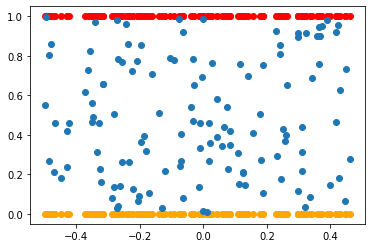

In [141]:
#Cloud Generator

domain_X = [-.5, .5]
domain_Y = [0, 1]

rng = np.random.default_rng(123)

def cloud(size=128):
  
  #interior
  X = rng.uniform(domain_X[0], domain_X[1], size)
  Y = rng.uniform(domain_Y[0], domain_Y[1], size)

  return (X, Y)

#Random Plotting in Domain
x, y = cloud(128)
plt.scatter(x, np.zeros_like(x), color='orange')
plt.scatter(x, np.ones_like(x), color='red')
plt.scatter(x, y)
plt.show()

In [57]:
class NSFnet_VP(nn.Module):
  def __init__(self):
    super().__init__()

    self.FC1 = nn.Linear(2, 64)
    self.AC1 = nn.Tanh()

    self.FC2 = nn.Linear(64, 128)
    self.AC2 = nn.Tanh()

    self.FC3 = nn.Linear(128, 2)

  def forward(self, x):
    out = self.AC1(self.FC1(x))
    out = self.AC2(self.FC2(out))
    out = self.FC3(out)
    return out

In [136]:
model = NSFnet_VP()
lr=0.003
optimizer = torch.optim.Adam(model.parameters(), lr)
epochs = 10000

In [137]:
for epoch in tqdm(range(epochs)):

  #Data
  size = 128
  x_sample, y_sample = cloud(size)
  x_t = torch.tensor(x_sample, dtype=torch.float, requires_grad=True)
  y_t = torch.tensor(y_sample, dtype=torch.float, requires_grad=True)
  data = torch.stack([torch.cat([x_t, x_t, x_t], dim=0), torch.cat([y_t, torch.ones_like(y_t), torch.zeros_like(y_t)])], dim=1)

  #PDE Predictions
  preds = model(data)
  u_preds = preds[:size, 0]#Velocity
  p_preds = preds[:size, 1]#Pressure

  # #Boundary Data
  # boundary_data = torch.stack([torch.cat([x_t, x_t], dim=0), torch.cat([torch.ones_like(x_t), torch.zeros_like(x_t)], dim=0)], dim=1)

  # #Boundary Predictions
  # b_preds = model(boundary_data.view(-1, 2))

  #Differentials
  du_dx = torch.autograd.grad(u_preds, x_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]
  du_dy = torch.autograd.grad(u_preds, y_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]
  d2u_dy2 = torch.autograd.grad(du_dy, y_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]

  dp_dx = torch.autograd.grad(p_preds, x_t, torch.ones_like(p_preds), create_graph=True, retain_graph=True)[0]
  dp_dy = torch.autograd.grad(p_preds, x_t, torch.ones_like(p_preds), create_graph=True, retain_graph=True)[0]

  #Losses
  mu = 1

  #PDE_Loss
  loss = torch.sum(du_dx**2)
  loss = loss + torch.sum(dp_dy**2)
  loss = loss + torch.sum((dp_dx-1/mu*(d2u_dy2))**2)
  loss_p = loss

  #Boundary Loss
  v = 1
  loss = torch.sum((preds[size:size*2,0]-v)**2)
  loss = loss+torch.sum((preds[size*2:size*3,0])**2)
  loss_b = loss

  alpha_b = 0.0001

  #Total loss
  loss = loss_p + alpha_b*loss_b 

  if(epoch%1000==0 or epoch==9999):
    print("PDE Loss:", loss_p.item(), ", Boundary Loss:", loss_b.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  0%|          | 9/10000 [00:00<02:01, 82.39it/s]

PDE Loss: 2.3060824871063232 , Boundary Loss: 82.49395751953125


 10%|█         | 1017/10000 [00:12<01:45, 85.25it/s]

PDE Loss: 0.0013301223516464233 , Boundary Loss: 30.29371452331543


 20%|██        | 2016/10000 [00:24<01:37, 81.95it/s]

PDE Loss: 0.00034690662869252264 , Boundary Loss: 8.527690887451172


 30%|███       | 3015/10000 [00:36<01:22, 84.48it/s]

PDE Loss: 0.0023993549402803183 , Boundary Loss: 3.1911392211914062


 40%|████      | 4014/10000 [00:48<01:11, 83.90it/s]

PDE Loss: 0.00023731222609058022 , Boundary Loss: 1.125364065170288


 50%|█████     | 5013/10000 [01:00<01:01, 81.45it/s]

PDE Loss: 0.003981321584433317 , Boundary Loss: 1.3586275577545166


 60%|██████    | 6009/10000 [01:12<00:47, 84.10it/s]

PDE Loss: 8.435369090875611e-05 , Boundary Loss: 1.9852948188781738


 70%|███████   | 7017/10000 [01:24<00:35, 83.97it/s]

PDE Loss: 3.061188544961624e-05 , Boundary Loss: 2.482577323913574


 80%|████████  | 8016/10000 [01:36<00:23, 84.35it/s]

PDE Loss: 5.8873942180071026e-05 , Boundary Loss: 1.1173269748687744


 90%|█████████ | 9015/10000 [01:48<00:11, 86.10it/s]

PDE Loss: 0.00029690947849303484 , Boundary Loss: 2.989156723022461


100%|██████████| 10000/10000 [01:59<00:00, 83.46it/s]


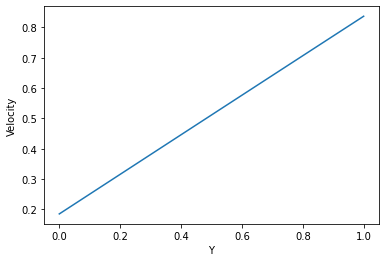

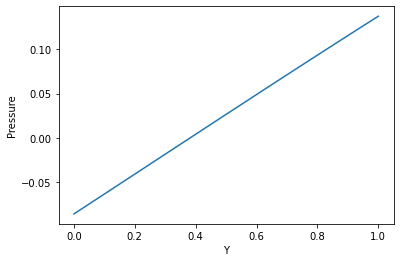

In [140]:
#Plotting Results

y = np.linspace(domain_Y[0], domain_Y[1], 100)
x = np.zeros_like(y)

x_t = torch.tensor(x, dtype=torch.float)
y_t = torch.tensor(y, dtype=torch.float)

with torch.no_grad():
  preds = model(torch.stack([x_t, y_t], dim=1))

u_preds = preds[:, 0].numpy()
p_preds = preds[:, 1].numpy()

plt.plot(y, u_preds,)
plt.xlabel('Y')
plt.ylabel('Velocity')
plt.show()

plt.plot(y, p_preds)
plt.xlabel('Y')
plt.ylabel('Pressure')
plt.show()